## Document/Word Visualization using Embedding

1. MDS
1. LLE
1. ISOMAP
1. t-SNE

## Create document-term matrix

2016-10-24 의 뉴스에 대하여 한글과 숫자만 남겨둔 파일을, mypy에 있는 corpus를 이용하여 읽어드립니다. term frequency matrix를 만들기 위함이니 iter_sent=False로 합니다. 

In [1]:
import config

def load_dictionary(path):
    with open(path, encoding='utf-8') as f:
        dictionary = {word.strip() for word in f}
        return dictionary

dic_path = 'noun_dictionary_small.txt'
dictionary = load_dictionary(dic_path)

soynlp=0.0.49
added lovit_textmining_dataset


In [2]:
import numpy as np
from navernews_10days import get_bow

x0, idx_to_vocab0, vocab_to_idx0 = get_bow(date='2016-10-20', tokenize='noun')

# select columns
indices = [vocab_to_idx0.get(vocab, -1) for vocab in dictionary]
indices = sorted([idx for idx in indices if idx != -1])
indices = np.asarray(indices)
idx_to_vocab = [idx_to_vocab0[idx] for idx in indices]
vocab_to_idx = {vocab:idx for idx, vocab in enumerate(idx_to_vocab)}

x = x0[:,indices]

print(x0.shape)
print(x.shape)

(30091, 9774)
(30091, 1090)


transpose()를 한 결과, 행렬의 모양이 뒤집어졌음을 확인할 수 있습니다. 

In [3]:
x = x.transpose()
print('term2doc matrix shape = {}, num term = {}'.format(
    str(x.shape), len(idx_to_vocab)))

term2doc matrix shape = (1090, 30091), num term = 1090


시각화를 위하여 행렬을 dense matrix로 변환하겠습니다. TSNE는 dense matrix 를 입력받도록 만들어져 있습니다. 

In [4]:
x_dense = x.todense()

sklearn.preprocessing의 normalize는 행렬을 정규화시켜줍니다. 

In [5]:
from sklearn.preprocessing import normalize
x_dense = normalize(x_dense, axis=1, norm='l2')

## matplotlib in Jupyter notebook

Jupyter notebook은 본래는 matplotlib의 그림이 출력되지 않습니다. 출력을 하기 위해서는 반드시 아래의 명령어를 실행시켜줘야 합니다. 

    %matplotlib inline

In [6]:
%matplotlib inline

## matplotlib 의 한글 폰트 설정

In [7]:
import matplotlib
import matplotlib.pyplot as plt

list(matplotlib.font_manager.get_fontconfig_fonts())[:5]

krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 10}
matplotlib.rc('font', **krfont)

## t-SNE

t-SNE 를 이용하여 문서 개수의 차원으로 표현된 단어 벡터를 2차원으로 시각화 시키겠습니다. sklearn의 manifold 에는 다양한 임베딩 알고리즘들이 구현되어 있습니다. 

    n_components: 임베딩할 공간의 크기를 의미합니다. 

팁으로, sklearn에 구현되어 있는 t-SNE는 [original t-SNE][original_tsne]가 아닌, 2014년에 동일한 저자가 발표한 [approximiated t-SNE][acce_tsne]입니다. 이 알고리즘은 O(N log N)의 비용으로 학습을 할 수 있지만, 그 마저도 데이터의 크기가 클 경우에는 매우 느립니다. 

한 가지, 현실적인 임베딩 방법 중 하나는, 중요한 데이터 포인트들을 샘플링하여 (예를 들어 빈도수가 높은, 혹은 키워드들) 먼저 임베딩을 시킨 뒤, 다른 데이터들은 가장 비슷한 몇 개의 점들의 임베딩 벡터의 평균 값으로 inferring 하는 것입니다. 

landmark t-SNE라고도 불리며, [original t-SNE][original_tsne]에서도 언급됩니다. 이 방법이 전체 데이터를 한 번에 임베딩하여 시각화 하는 것보다 좋은 이유도 있습니다. 빈도수가 작은 단어들은 몇 번 등장하지 않았기 때문에, 빈도수가 높은 단어들보다 좀 더 틀려도 됩니다. 반대로 자주 등장하는 단어들은 어떤 큰 구조를 잡는데 훨씬 더 중요할 것입니다. 그러나 알고리즘은 이런 빈도수를 고려하지 않고, 모든 단어간 거리의 중요도가 동일합니다. 그렇기 때문에 중요한 단어부터 먼저 임베딩 하는 것도 아주 좋은 방법입니다. 


[original_tsne]: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
[acce_tsne]: http://www.jmlr.org/papers/volume15/vandermaaten14a/source/vandermaaten14a.pdf

In [8]:
from sklearn.manifold import TSNE

In [9]:
%%time 

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)
y_tsne = tsne.fit_transform(x_dense)

y_tsne.shape

CPU times: user 59.9 s, sys: 148 ms, total: 1min
Wall time: 1min


scatter plot을 통하여 2차원으로 학습된 각 단어의 벡터를 시각화 하였습니다. 일본/중국/미국은 나라임에도 불구하고 멀리 떨어져 있습니다. 이는 같은 문서에서 등장했던 경우가 적기 때문입니다. 

문서 빈도로 표현된 단어 벡터가 유사하다는 것은 topic modeling 의 관점입니다. 일본/중국/미국이 같은 문맥에서 등장한다는 것은 word2vec과 같은 어문학적인 semantic similarity에 기반한 생각입니다. 

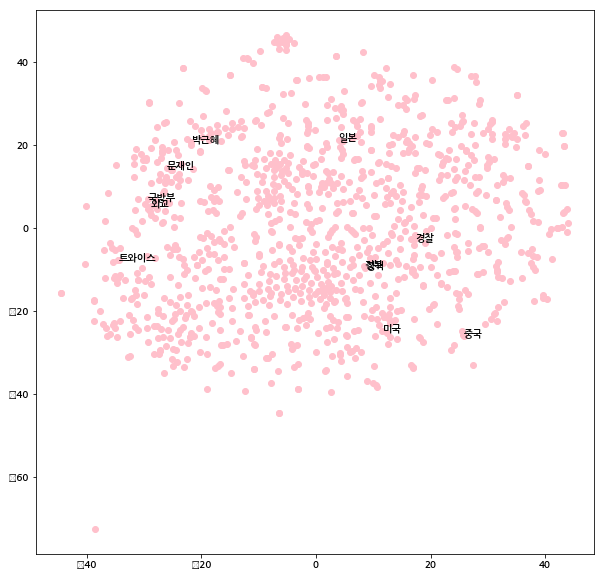

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def print_scatterplot(words, y):
    
    plt.figure(figsize=(10,10))
    plt.scatter(y[:,0], y[:,1], color='pink')

    for word in words:
        idx = vocab_to_idx.get(word, -1)
        if idx == -1:
            continue
        plt.annotate(word, (y[idx, 0], y[idx, 1]))

    plt.show()

words = '김무성 박근혜 문재인 국방부 정부 국정원 대통령 축구 야구 외교 정책 군대 미국 일본 중국 트와이스 경찰'.split()
print_scatterplot(words, y_tsne)

## MDS

그 외에 MDS를 이용하여 동일한 작업을 수행하였습니다. 

t-SNE가 구 형이긴 하지만, 울퉁불퉁한 모양을 하고 있다면, MDS는 구 형과 비슷한 모양을 보입니다. 

In [12]:
%%time 

from sklearn.manifold import MDS

mds = MDS(n_components=2)
y_mds = mds.fit_transform(x_dense)

y_mds.shape

CPU times: user 1min 19s, sys: 3min 19s, total: 4min 38s
Wall time: 23.6 s


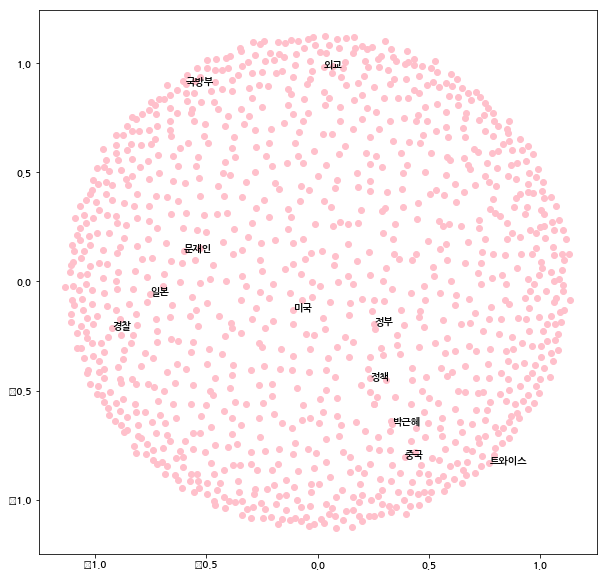

In [13]:
print_scatterplot(words, y_mds)

## LLE

LLE와 ISOMAP은 k-NN 구조가 아주 뚜렷하게 잘 표현되는 데이터에 대해서는 그 모양이 잘 나옵니다. (예를 들어 Swissroll data). 그러나 두 알고리즘 모두, 최인접이웃의 구조가 뚜렷하지 않을 경우 (=이웃간 거리가 큰 차이가 없을 경우) 모양이 매우 민감하게 꼬이는 경향이 있습니다. 

특히 단어를 문서 벡터로 표현한 경우에는, 지나친 고차원이기 때문에 많은 단어들이 하나의 군집으로 묶이는 것처럼 보입니다. 이런 경우에는 모양이 좋지 않게 학습됩니다. 

경험적으로는 t-SNE보다 민감하게 학습모양이 바뀌는 경향이 있습니다. 

In [14]:
%%time 

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2)
y_lle = lle.fit_transform(x_dense)

y_lle.shape

CPU times: user 56.6 s, sys: 2.57 s, total: 59.2 s
Wall time: 57.1 s


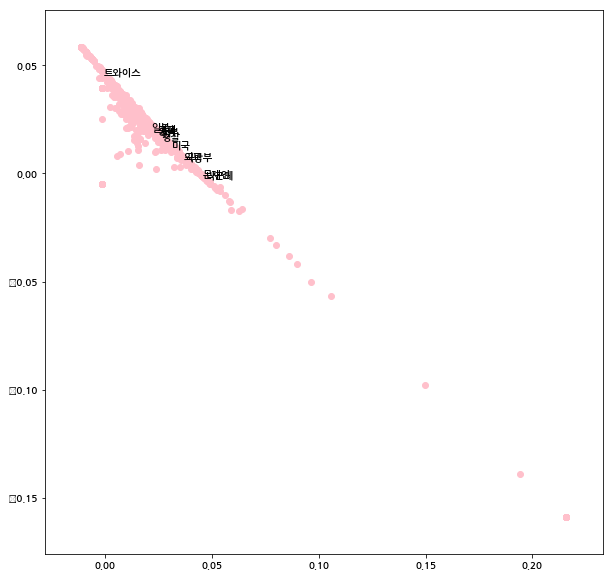

In [15]:
print_scatterplot(words, y_lle)

## ISOMAP

In [16]:
%%time 

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
y_isomap = isomap.fit_transform(x_dense)

y_isomap.shape

CPU times: user 53.3 s, sys: 304 ms, total: 53.6 s
Wall time: 53.4 s


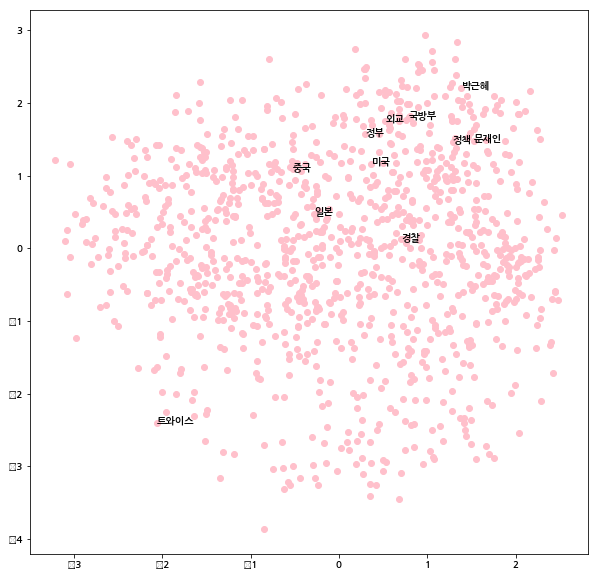

In [17]:
print_scatterplot(words, y_isomap)